<a href="https://colab.research.google.com/github/bgeven/8DM50_Group4/blob/main/Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data synthesis using generative adversarial networks (GANs)

In this practical session we will build and train generative adversarial networks that are able to generate images.

This is a Google Colab notebook, which is mostly the same as a Jupyter notebook. This means that you can run the code in a cell by selecting the cell and pressing Shift+Enter. We will run everything in the cloud, so you don't need a fancy computer or an expensive GPU for this exercise. We are going to use GPUs that Google Cloud provides for free. To do this, go to Edit --> Notebook settings and select GPU as Hardware accelerator. Then, in the top right of this screen select 'CONNECT' --> 'Connect to hosted runtime'

We are going to import some of the packages that we will need in this exercise (by running the cell below)

The documentation for key packages can be found online: <br>
For numpy: https://docs.scipy.org/doc/numpy-dev/user/quickstart.html <br>
For matplotlib: http://matplotlib.org/api/pyplot_api.html <br>
For Keras: https://keras.io/ <br>
For random: https://docs.python.org/2/library/random.html <br>

In [4]:
%tensorflow_version 1.x
import pickle
import gzip
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
from matplotlib import pylab
from IPython import display

import tensorflow as tf
import keras
keras.backend.set_image_data_format('channels_first')

import time
import random
from google.colab import files
from google.colab import widgets
random.seed(0)

# Check whether we're using a GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.logging.set_verbosity(tf.logging.ERROR)

TensorFlow 1.x selected.


Using TensorFlow backend.


Found GPU at: /device:GPU:0


## Small steps
Before moving on to generating images, we will start with a simple 1D problem. We will assume that there is a data set of real samples that are drawn from a normal distribution with a particular mean value (the black dotted line below). These samples are in the sample domain *x*. 

The generator network does not know anything about the distribution of the real samples in the sample domain *x*, but will try to come up with a transformation that maps random noise from a distribution *z* to samples that seem to come from the real sample distribution (the green line below). This is very similar to what we have looked at in the lecture.

<img src="https://cs.stanford.edu/people/karpathy/gan/gan.png">

For this, we will define two neural networks that play a game:
*   The discriminator will learn to distinguish real and fake samples in *z*
*   The generator will generate fake samples in *z* that the discriminator cannot discriminate

First, we determine the mean value of the normal distribution from which **real** samples will be drawn in the sample domain *x*. In addition, we define the dimensionality of the normal distribution *z* from which noise samples to the generator will be drawn, i.e. the latent space. This will be 1 for now.

In [5]:
real_mean = 8
latent_dim = 1

Next, we define our discriminator and generator. These are both very simple networks.

**Question 1:** How many layers does each of these networks have? 

**Answer 1:** The discriminator and generator both have two layers, both dense layers.

**Question 2:** Can you find out how many trainable parameters the networks have?

**Answer 2:** The first dense layer has 64 trainable parameters (32 * (1+1)), the LeakyReLU has no trainable parameters and the second dense layer has (1 * (32 + 1)) trainable parameters. In total the network has 97 trainable parameters. 

**Question 3:** What are the activation functions of both networks? Why are they like this? 

**Answer 3:** Both networks use LeakyReLU as activation function between the two layers. For the dense layer in the discriminator a sigmoid function is used and for the dense layer in the generator no activation function is used (not needed as it has to output an image). The sigmoid function is used because it exists between 0 an 1 so it is useful to predict the probability (distinguish real and fake).

In [6]:
# For easier reading
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU

# The discriminator will directly classify the input value
def get_discriminator_1D():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(32, input_dim=1))
  discriminator.add(LeakyReLU())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

# The generator will transform a single input value
def get_generator_1D():
  generator = keras.models.Sequential()
  generator.add(Dense(32, input_dim=1))
  generator.add(LeakyReLU())
  generator.add(Dense(1))
  return generator

Now, we will define the training functions for both networks. Consider what is actually happening in a GAN and how the inputs and outputs are connected. There are three variables when training this GAN

*   **z**: the noise that will be input to the generator
*   **G_z**: the output of the generator, i.e. the samples that should approximate the real samples
*   **D_G_z**: the discriminator's decision based on the fake sample

The overall objective function of our system is as follows

$V^{(D)}(D,G)=\underset{x\sim p_{data}}{\mathbb{E}} [\log{D(x)}]+\underset{z\sim p_z}{\mathbb{E}} [\log{(1-D(G(z)))}]$

The generator $G$ is trying to minimize this loss, and the discriminator $D$ tries to maximize this. In other words, the discriminator wants to minimize the binary cross-entropy s.t. it predicts 1 for real samples and 0 for fake samples. At the same time, the generator tries to get the discriminator to predict 1 for fake samples.




In [7]:
# Get networks
discriminator = get_discriminator_1D()
generator = get_generator_1D()

# Configure both models for training
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

# To configure the full model, we will set the 'trainable' parameter of the discriminator to False, as we don't want to optimize the discriminator when optimizing the generator
discriminator.trainable = False

# The input variable (noise) for the generator
z = keras.layers.Input(shape=(latent_dim,))

# What comes out of the generator
G_z = generator(z)

# What comes out of the discriminator when classifying the 'fake' samples
D_G_z = discriminator(G_z)

# The full GAN model
gan = keras.models.Model(inputs=z, outputs=D_G_z)

# The loss function for the GAN: this gets lower if the fake samples are classified as real
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

The code below runs the training loop. This could take a while. The code will periodically show a plot of the current situation.

**Question 4:** Why do we set discriminator.trainable to either True or False?

**Answer 4:** Because the discriminator has to distinguish real and fake samples. Real samples will be indicated with True and fake samples will be indicated with False.

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

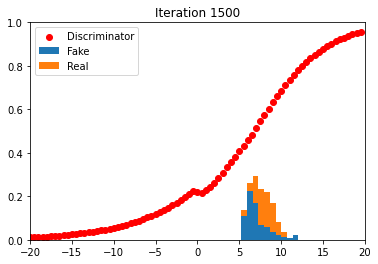

<IPython.core.display.Javascript object>

In [ ]:
# We will store the losses here
g_losses = []
d_losses = []

# Training loop
n_samples = 100
epochs = 10000

grid = widgets.Grid(1, 1)

for e in range(epochs):
  # Get a random Gaussian set of input noise
  #noise = np.random.normal(0, 1, size=[n_samples, latent_dim])

  # Get a random uniform set of input noise
  noise = np.random.uniform(0, 1, size=[n_samples, latent_dim])

  # Also get a sample from the 'real' distribution
  real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])

  # Generate some fake samples using the generator
  fake = generator.predict(noise)

  # Concatenate the fake and real images
  X = np.concatenate([real, fake])

  # Labels for generated and real data
  Y_dis = np.zeros(2*n_samples)
  
  # Set labels for real samples to 1
  Y_dis[:n_samples] = 1

  # Train discriminator with this batch of samples
  discriminator.trainable = True
  d_loss = discriminator.train_on_batch(X, Y_dis)
  d_losses.append(d_loss)
  
  # Train generator with a new batch of generated samples
  # Freeze the discriminator part
  discriminator.trainable = False 
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
  # From the generator's perspective, the discriminator should predict
  # ones for all samples
  Y_gen = np.ones(n_samples)
  g_loss = gan.train_on_batch(noise, Y_gen)
  g_losses.append(g_loss)
  
  if e % 100 == 0:
    noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
    fake = generator.predict(noise)        
    real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])
    pred = discriminator.predict(np.arange(-20, 20, 0.5).reshape((80, 1)))
    with grid.output_to(0, 0):
      grid.clear_cell()
      
      # plt.clf()
      pylab.hist((np.squeeze(fake), np.squeeze(real)), density=True, stacked=True)
      pylab.scatter(np.arange(-20, 20, 0.5), pred, c='r')     
      pylab.xlim(-20, 20)
      pylab.ylim(0, 1)
      pylab.title('Iteration {}'.format(e))
      pylab.legend(['Discriminator', 'Fake', 'Real'])
    time.sleep(0.5)

If all is well, the fake and real distributions should nicely overlap after training. The discriminator has essentially pushed the fake samples towards the real distribution and the generator is now able to transform the noise distribution into a distribution of 'real' samples!

**Question 5:** Can you explain what happened to the red line during training? Why does it look like it does after training?

**Answer 5:** The discriminator becomes better and pushes the fake samples towards the real distribution and a balance exists between the discriminator and generator. Therefore, the red line (discriminator) goes towards 0.5.

**Question 6:** Try training the GAN with different input noise distributions, e.g. uniform. See if you can find a distribution for the real samples for which the generator fails to generate samples.

**Answer 6:** ????

During training, we have stored the loss values for the discriminator and the generator. We can now plot these. Remember that for the digit classification task, we were looking for a set of parameters leading to a low loss function. 

**Question 7:** The loss curves that you get look different. Can you explain why they're not nicely dropping to zero? Can you explain the loss in the discriminator based on the objective function of the discriminator?

**Answer 7:** The generator tries to minimize the loss function and the discriminator tries to maximize it. The reason for the discriminator not dropping to zero and the generator to be closer to one means that the generator is successful at generating fake samples which are classified as real by the discriminator. The point of these functions is to have losses that counterbalance one another. If the loss of the discriminator drops to zero it means that the discriminator is doing a too good job (can distinguish real and fake) and the generator does a too bad job (generations are not close enough to the real data). So, if one of the losses goes to zero, it means that the system is failing, and the generator cannot improve in the next iteration.

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Although it is definitely nice that we can train two networks together to learn the distribution of a real data distribution, generating samples from a normal distribution is in itself not really interesting. Luckily, we can use the same principles to generate images.

# MNIST synthesis
Like last week, we are again going to use MNIST data. Data preparation is the same as before.

In [1]:
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
train_set_images = np.expand_dims(x_train, axis=-1)
test_set_images = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
train_set_labels = to_categorical(y_train, num_classes=10)
test_set_labels = to_categorical(y_test, num_classes=10)

ImportError: ignored

Plot some images.

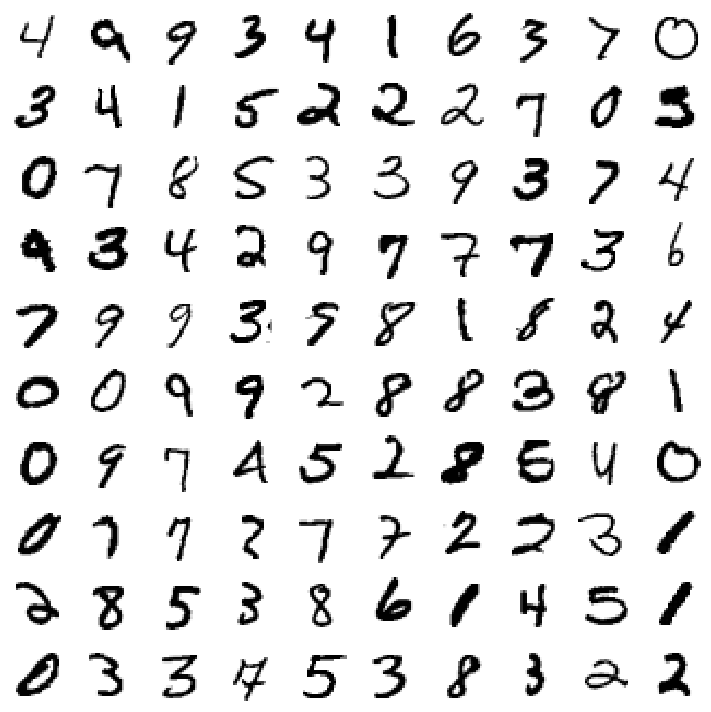

In [ ]:
def plotImages(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plotImages(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28))

In last week's exercise you have built a discriminative model that was able to classify an image into one of ten digit categories. In this exercise, we are going to do the inverse. Given a point in a latent space (which in our case will be a multi-dimensional Gaussian distribution), we are going to train the network to generate a realistic digit image for this point. The MNIST data set will be used as a set of real samples. 

<img src="https://skymind.ai/images/wiki/GANs.png">



## The discriminator
As you can see in the image above, we will need a generator and a discriminator network. Let's define these. Consider the network that you used
for digit classification in the previous exercise and see if you can spot some differences between that network and the network below.

**Question 8:** Is this a convolutional neural network? Why (not)?

**Answer 8:** No this is not a convolutional network as it does not consist of convolutional layers. It is a multilayer perceptron.


In [ ]:
def get_discriminator_MLP():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

You could argue that digits are a bit more complex than samples from a Gaussian distribution, so let's set the latent space dimensionality for noise sampling a bit higher than 1.

In [ ]:
latent_dim = 10


## The generator

The generator is different than the discriminator. It should go from a low-dimensional noise vector to an MNIST image.

In [ ]:
def get_generator_MLP():
  generator = keras.models.Sequential()
  generator.add(Dense(256, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(784, activation='tanh'))
  return generator

**Question 9:** Consider the activation functions of the output layers of the generator and discriminator networks. How are they different?

**Answer 9:** The discriminator has a sigmoid activation function in the output layer and the generator has a tanh activation function. These both have the same S-shape but the sigmoid function lies between 0 an 1 and the tanh function between -1 and 1.

**Question 10:** Also look at the activation functions of the other layers, can you find out what they do? Look at the Keras documentation.

**Answer 10:** The other activation function which is used in both the discriminator and generator network is a leakyReLU. This is an improved version of the ReLU and allows a small gradient from inputs that are less then zero. This prevents that these neurons are deactivated.

## The model
Now  let's combine the generator and the discriminator. We train both using a binary crossentropy objective. This is very similar to what we did before.

In [ ]:
discriminator = get_discriminator_MLP()
generator = get_generator_MLP()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
G_z = generator(z)
D_G_z = discriminator(G_z)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

Some helper functions.

In [ ]:
def saveModels(epoch):
    generator.save('gan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('gan_discriminator_epoch_{}.h5'.format(epoch))
    
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Epoch {}'.format(epoch))
    plt.show()

Run the code below to train the GAN model. Synthesized images should be shown periodically. 

In [ ]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

X_train = (train_set_images.reshape(60000, 784).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):

    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # One-sided label smoothing
    y_dis[:batch_size] = 0.9

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

  # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    plotGeneratedImages(e)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    saveModels(e)
  elif e == 199:
    display.display(plt.gcf())

<Figure size 432x288 with 0 Axes>

**Question 11:** Inspect the loss curves for this model and explain what happens.

**Answer 11:** The loss of the discriminator increases which means that it becomes better at distinguishing real and fake samples generated by the generator. The loss of the generator decreases which means that it becomes better at generating images which are identified as real by the discriminator.

No handles with labels found to put in legend.


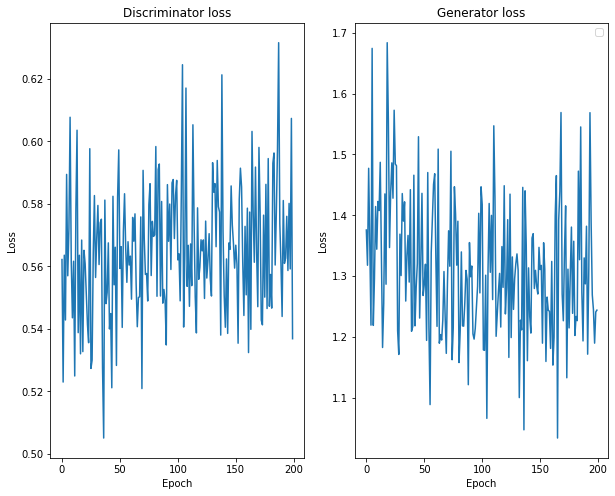

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## A convolutional model
Thus far the discriminator and generator were both multilayer perceptrons. Now we're going to add in some convolutional layers to turn them into a deep convolutional GAN (<a href="http://arxiv.org/abs/1511.06434">DCGAN</a>)-like architecture. This means that we have to redefine the generator network and a discriminator network. 

The discriminator network is (almost) the same network that we used in last week's exercise.

In [ ]:
from keras.layers.convolutional import Conv2D, UpSampling2D

def get_discriminator_CNN():
  discriminator = keras.models.Sequential()
  discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

def get_generator_CNN():
  generator = keras.models.Sequential()
  generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((128, 7, 7)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
  return generator

Let's build our model like before.

In [ ]:
discriminator = get_discriminator_CNN()
generator = get_generator_CNN()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
x = generator(z)
D_G_z = discriminator(x)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

Train the model using the code below. Inspect the samples that come out. 

**Question 12:** What are some differences between these samples and the ones generated by the multilayer perceptron GAN? Can you explain these differences?

**Answer 12:** The samples generated from the convolutional GAN have no filled circles with the 8 and 6 as in the multilayer GAN.

In [ ]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

X_train = (train_set_images.reshape(60000, 1, 28, 28).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):
    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(100, 28, 28)          
    plotImages(generatedImages, title='Epoch {}'.format(e))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)    
    saveModels(e)

  elif e == 199:
    display.display(plt.gcf())

NameError: ignored

## Interpolation in the latent space
We're going to explore the latent space a bit more. We pick two points in the latent space and make a linear interpolation between these two. Then we generate images from each of the interpolated latent points. 

In [ ]:
noise_a = np.random.normal(0, 1, size=[1, latent_dim])
noise_b = np.random.normal(0, 1, size=[1, latent_dim])

noise = np.zeros((10, latent_dim), dtype='float32')
for ni in range(10):
  noise[ni, :] = float(ni)/10. * noise_a + (1 - float(ni)/10.) * noise_b
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(10, 28, 28)          
plotImages(generatedImages, dim=(1, 10), figsize=(10, 10))

ValueError: ignored

**Question 13** Explain what you see in this plot.

**Answer 13** This plot shows ten times the digit 9. From the first digit to the nineth digit, the diameter of the round  increases and the tail becomes larger and more rounded.

**Question 14** What happens when you extrapolate out of the latent space distribution? Consider how the noise vectors are drawn.

**Answer 14** 

# Histopathology image synthesis

Now we're going to synthesize some actual images. We're going to use the PatchCamelyon data set ([more info here](https://github.com/basveeling/pcam)) which consists of small images that can be used for classification benchmarks. Today, we're not going to classify images, but we're going to synthesize them. You can download a data set of smaller (28 x 28 pixels) versions of these images from 
[this link](https://drive.google.com/file/d/11tkBWleY6PqFAGQHW0zYOwhvuz0kq-ai/view?usp=sharing). Upload the data set in the dialog below.

In [1]:
from google.colab import files

uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

Now load the data set.

In [3]:
import gzip
def loadPatchCamelyon(path):    
    f = gzip.open(path, 'rb')
    train_set = pickle.load(f, encoding='latin1')
    f.close()
    return train_set

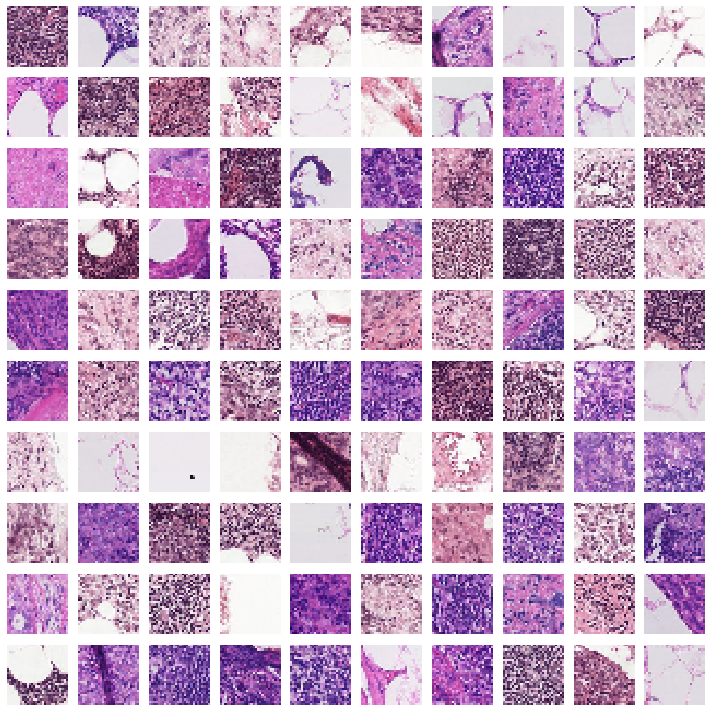

In [9]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt

train_set_images = loadPatchCamelyon('C:/Users/20182104/Documents/TUe/Jaar 4/Machine Learning/8DM50_Group4/Assignment_week_5/valid_28.pkl.gz')

def plotImagesPatchCamelyon(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
    
plotImagesPatchCamelyon(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28, 3)/255.0)

What do you immediately notice? Indeed, these images are in color! So the generator will have to generate three output channels instead of just one. 

In this second-to-last part of the practical you're going to repurpose the code that you have used so far to synthesize histopathology images like the ones above. You can play around a bit with this, see what happens when you interpolate between samples, etc. Remember that there is a final 'exercise' below.

**Good luck!**

In [ ]:
## YOUR CODE GOES HERE

# Conditional image synthesis

## The BigGAN model
The images we have synthesized so far are all quite small. Synthesis of larger images (e.g. 512 x 512 pixels) typically requires a lot of compute power and patience. Unfortunately, you don't have 100s of GPU at your disposal (I guess) to train a model like BigGAN, the state of the art in conditional image synthesis. A wild guess is that it would cost you around [USD60000](https://twitter.com/quasimondo/status/1065610256917692416) to train this model.

Luckily, the authors of BigGAN have put a version of their pretrained model online and you can use it to synthesize images. Go to [this Colaboratory file](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb) and answer the following questions.

**Question 15:** What happens when you change the noise seed? Also try out different categories.

**Answer 15:** When the noise is set to 0, the images look very much the same

Increasing the noise-seed leads to more variance o

Thus, the addition of noise prevents overfitting and generalization, it leads to more variance in the created samples. 

**Question 16:** What happens to your samples when you change the truncation value? More precisely, what happens to the diversity and the quality of your samples? Take a look at the [paper on arXiv](https://arxiv.org/abs/1809.11096) Sec. 3.1 to get an idea what this value does.

**Answer 16:** The truncation level controls the trade-off between sample variety and fidelity. A low truncation levels generates the same samples and a high truncation level generates not all realistic samples. So, with a higher truncation level the diversity increases but the quality decreases.

**Question 17:** Interpolate between image categories, inspect what these look like. 

**Answer 17:** From the left to the right category A (dog) smoothly transitions into category B (hen). First the size/posture changes and then the hair.

## Conditional MNIST synthesis
For all MNIST samples we already have labels (0, 1, ..., n). Try to change the MNIST synthesis code such that you can ask the generator to generate specific labels. I.e., try to train a conditional GAN. You can look for some inspiration in [this paper](https://arxiv.org/pdf/1411.1784.pdf), in particular Sec. 4.1. Remember that you already got the MNIST labels when loading the data set.

# Pretrained models

You can download some pre-trained generator models for the GAN training exercises from [this link](https://filesender.surf.nl/?s=download&token=475362bb-4098-4376-979b-b0d3ae9e3dd0), but of course it's much more interesting to train them yourself. Use 


```
generator = keras.models.load_model(filename)
```

to load the model.
